In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import mne
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
def read_data(path,event_id):
    
    raw = mne.io.read_raw_brainvision(path,eog=['hEOG_L','hEOG_R','vEOG_U','vEOG_D'])
    raw.drop_channels(['hEOG_L','hEOG_R','vEOG_U','vEOG_D','EMG_1','EMG_2','EMG_3','EMG_4','EMG_5','EMG_6','EMG_ref'])
    events, event_dict =mne.events_from_annotations(raw)
    epoch=mne.Epochs(raw,events,event_id=event_id,tmin=-0.5,tmax=4,baseline=(-0.5,0))
    
    labels = epoch.events[:,-1]
    data=epoch.get_data()
    
    return data ,labels

In [5]:
s11='/Users/siddharth/Desktop/EEG_Classifier/Code/session1_sub11_reaching_MI.vhdr'
paths=[s11]
event_id=[11, 21, 31,41,51,61]
full_labels=[]
full_data=[]

for path in paths:
    data,labels=read_data(path,event_id)
    full_labels.append(labels)
    full_data.append(data)

full_data=np.vstack(full_data)
full_labels=np.hstack(full_labels)

print(full_labels)

Extracting parameters from /Users/siddharth/Desktop/EEG_Classifier/Code/session1_sub11_reaching_MI.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 300 events and 11251 original time points ...
0 bad epochs dropped
[11 31 51 51 31 31 41 51 21 41 31 41 11 51 61 51 61 11 31 31 11 41 41 61
 61 51 61 11 11 21 21 61 11 41 11 51 11 11 11 51 51 51 51 31 21 21 31 61
 41 21 61 31 11 61 31 41 21 51 41 61 31 31 61 31 11 31 31 11 41 31 61 21
 11 61 11 41 61 61 21 11 31 41 11 51 41 31 51 11 11 31 51 51 31 11 11 41
 51 41 61 61 61 41 41 31 21 41 61 3

In [6]:
full_data.shape

(300, 60, 11251)

In [7]:
import scipy.signal 
from scipy.signal import butter,lfilter

def bandpass(trials, lo, hi, sample_rate):

    a, b = scipy.signal.iirfilter(4, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)],ftype='butter')
    # Applying the filter to each trial
    ntrials = trials.shape[0]
    nchannels=trials.shape[1]
    nsamples=trials.shape[2]
    trials_filt = np.zeros((ntrials,nchannels, nsamples))
    for i in range(ntrials):
        trials_filt[i,:,:] = scipy.signal.filtfilt(a, b, trials[i,:,:], axis=1)
    
    return trials_filt
# final_features=bandpass(final_features,8, 30, sample_rate=1250)

In [8]:
def preprocess_using_wavelet(filtered_signal):  
    import pywt
    from pywt import wavedec ,waverec

    wavelet = 'db4'
    level = 5
    
    # db8,level 5
    # Daubechies sym7
    coeffs = pywt.wavedec(filtered_signal, wavelet, level=level)
    
    for i in range(1, level):
        coeffs[i] = np.zeros_like(coeffs[i])

    res = pywt.waverec(coeffs, wavelet)
    return res

In [9]:
def logvar(trials):

    return np.log(np.var(trials, axis=2))

In [10]:
def rolling_mean(arr):
    window_size = 5
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:

        window = arr[i : i + window_size]

        window_average = sum(window) / window_size
        moving_averages.append(window_average)
        
        i += 1
  
    return moving_averages

In [11]:
def compute(epoch):
    new_channels = []
    for channel in epoch:
        new_channel =rolling_mean(channel)
        new_channels.append(new_channel)
    return np.array(new_channels)


###########

def moving_average(trials):
    final_features = []
    for epoch in trials:
        new_epoch = compute(epoch)
        final_features.append(new_epoch)

    final_features = np.array(final_features)
    print(final_features.shape)
    return  final_features

In [12]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import pacf
def compute_statistical(epochs): 
    import pywt
# Assuming your data is stored as epochs with shape (300, 60, 10000)
    # Compute statistical features for each epoch
    statistical_features = []
    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            
#             scales = np.arange(1, 5)
#             wavelet='mexh'
#             coefs, freqs = pywt.cwt(channel,scales,wavelet ) 
#                 coefs,                                 #cwt coefs
#                 acf(channel, nlags=10, method='ywadjusted', alpha=None) #partial autocorrelation
                
            channel_features = [
                
                np.mean(channel),                    # Mean
                np.std(channel),                     # Standard Deviation
                np.var(channel),                     # Variance
                skew(channel),                        # Skewness
                kurtosis(channel),                # Kurtosis
                np.sqrt(np.mean(channel**2)),
                np.mean(channel**2),
                np.max(np.abs(channel)),
                np.ptp(channel),
                np.max(np.abs(channel))/np.sqrt(np.mean(channel**2)),
                np.sqrt(np.mean(channel**2))/np.mean(channel),
                np.max(np.abs(channel))/np.mean(channel),

            ]
            epoch_features.extend(channel_features)
#         epoch_features = np.array(epoch_features)
        statistical_features.append(epoch_features)

    statistical_features = np.array(statistical_features)

    # Print the shape of the computed statistical features
    print("Statistical features shape:", statistical_features.shape)

    return statistical_features

In [13]:
# #  using when computing statistical features
# def preprocessing(raw_data):
    
#     #Normalize min max
#     fe=raw_data
#     normalized_data=(fe - np.min(fe, axis=2, keepdims=True))/ (np.max(fe, axis=2, keepdims=True)-np.min(fe, axis=2, keepdims=True))
#     normalized_data=moving_average(normalized_data)
    
#     idx=0
#     plt.figure(figsize=(7,5))
#     plt.plot(normalized_data[:,0,:][idx])
#     plt.title('Normalized')
#     plt.show()
#     print(normalized_data.shape)
    
#     ttrain=compute_statistical(normalized_data)
#     print(ttrain.shape)
#     return ttrain

In [14]:
# # #  using when computing DWT
# def preprocessing(raw_data):
    
#     fe=raw_data
#     #(trials,channels ,samples)
#     normalized_data=(fe - np.mean(fe, axis=2, keepdims=True))/ np.std(fe, axis=2, keepdims=True)
#     idx=0
#     plt.figure(figsize=(7,5))
#     plt.plot(normalized_data[:,0,:][idx])
#     plt.title('Normalized')
#     plt.show()
#     print(normalized_data.shape)
    
#     #filter
#     lo, hi=8,30
#     filtered_data=bandpass(normalized_data,lo, hi, sample_rate=2500)
    
#     plt.figure(figsize=(7,5))
#     plt.plot(filtered_data[:,0,:][idx])
#     plt.title('Filtered')
#     plt.show()
#     print(filtered_data.shape)
    
#     #DWT
    
#     dwt_data=preprocess_using_wavelet(filtered_data)
    
#     plt.figure(figsize=(7,5))
#     plt.plot(dwt_data[:,0,:][idx])
#     plt.title('DWT')
#     plt.show()
    
#     #logvar
#     res=logvar(dwt_data)

#     return res

In [15]:
# using when computing CSP
def preprocessing(raw_data):
    
    fe=raw_data
    #(trials,channels ,samples)
    normalized_data=(fe - np.mean(fe, axis=2, keepdims=True))/ np.std(fe, axis=2, keepdims=True)

    idx=0
    plt.figure(figsize=(7,5))
    plt.plot(normalized_data[:,0,:][idx])
    plt.title('Normalized')
    plt.show()
    print(normalized_data.shape)

    #filter
    lo, hi=8,30
    filtered_data=bandpass(normalized_data,lo, hi, sample_rate=2500)
    
    
    plt.figure(figsize=(7,5))
    plt.plot(filtered_data[:,0,:][idx])
    plt.title('Filtered')
    plt.show()
    print(filtered_data.shape)

    return filtered_data

In [16]:
len(full_labels)

300

In [17]:
from sklearn.preprocessing import LabelEncoder

lb=LabelEncoder()
full_labels=lb.fit_transform(full_labels)

In [18]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(full_data, full_labels, test_size = 0.2,random_state=40,stratify=full_labels,shuffle=True)

xtrain.shape ,xtest.shape 

((240, 60, 11251), (60, 60, 11251))

In [19]:
ytrain.shape,ytest.shape

((240,), (60,))

In [20]:
late_test1=xtest[16]
late_label1=ytest[16]

late_test2=xtest[25]
late_label2=ytest[25]
late_test1.shape,late_test2.shape,late_label1,late_label2

((60, 11251), (60, 11251), 1, 0)

In [21]:
ytest

array([2, 5, 3, 4, 1, 2, 3, 5, 3, 5, 3, 4, 1, 3, 4, 1, 1, 0, 5, 3, 4, 4,
       5, 4, 3, 0, 3, 1, 4, 2, 0, 4, 2, 0, 0, 5, 5, 5, 2, 0, 0, 1, 0, 0,
       5, 2, 2, 2, 1, 3, 1, 4, 3, 1, 5, 1, 0, 2, 2, 4])

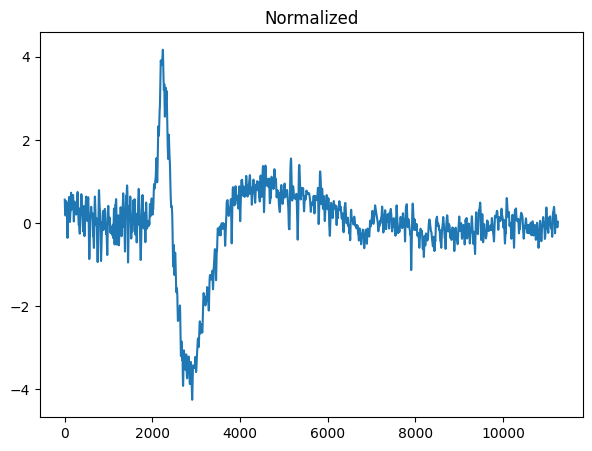

(240, 60, 11251)


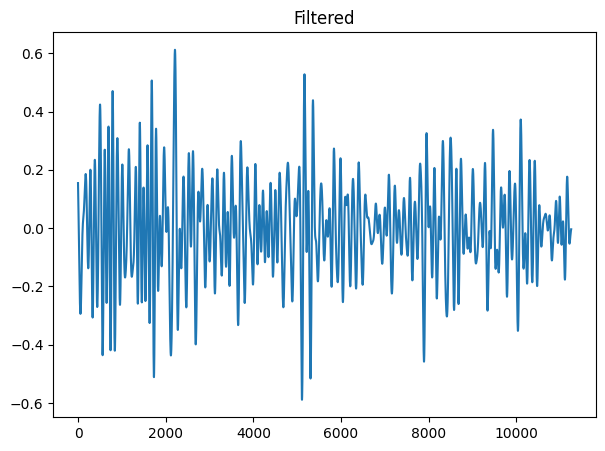

(240, 60, 11251)


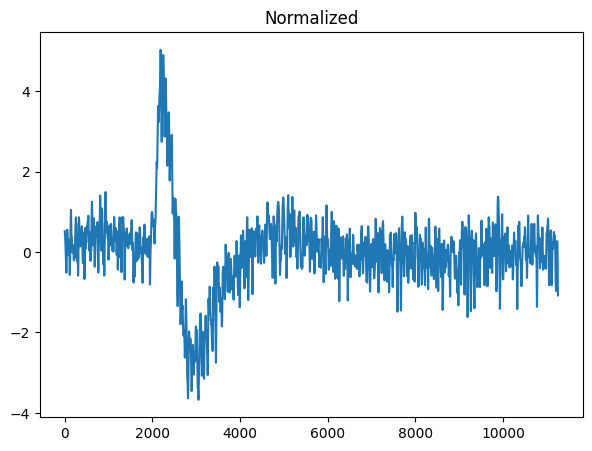

(60, 60, 11251)


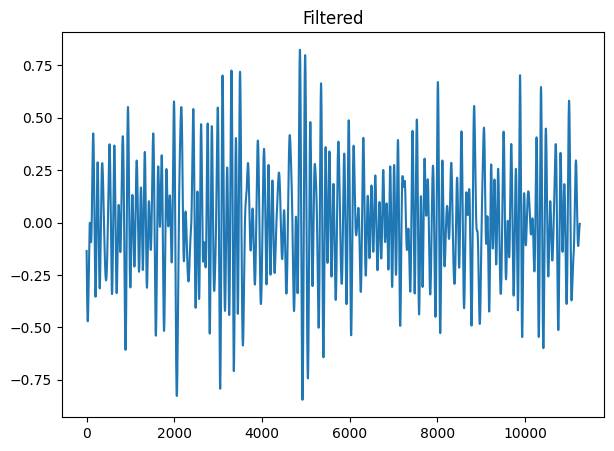

(60, 60, 11251)


In [22]:
xtrain = preprocessing(xtrain)
xtest = preprocessing(xtest)

In [23]:
xtrain.shape , xtest.shape

((240, 60, 11251), (60, 60, 11251))

In [24]:
# #  using when computing statistical features
# from sklearn.decomposition import PCA

# pca=PCA(30)
# xtrain=pca.fit_transform(xtrain)

# xtest=pca.transform(xtest)
# xtrain.shape,xtest.shape

In [25]:
# using when computing CSP
from mne.decoding import CSP

csp = CSP(n_components=60, reg=None, log=True,norm_trace=False)

xtrain = csp.fit_transform(xtrain,ytrain) 
xtest = csp.transform(xtest)

Computing rank from data with rank=None
    Using tolerance 23 (2.2e-16 eps * 60 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 22 (2.2e-16 eps * 60 dim * 1.6e+15  max singular value)
    Estimated rank (

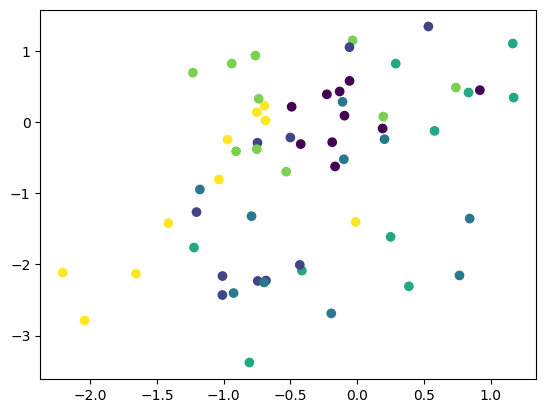

In [26]:
plt.scatter(xtest[:,0],xtest[:,1],c=ytest)

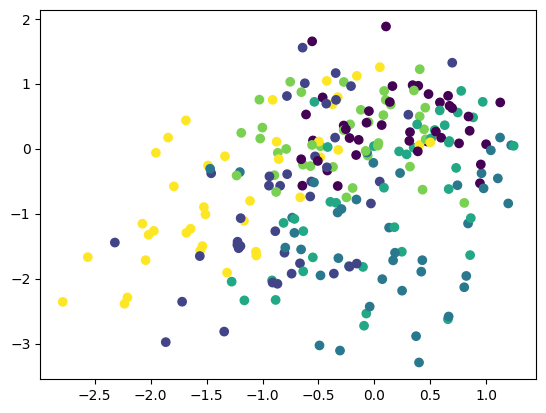

In [27]:
plt.scatter(xtrain[:,0],xtrain[:,1],c=ytrain)

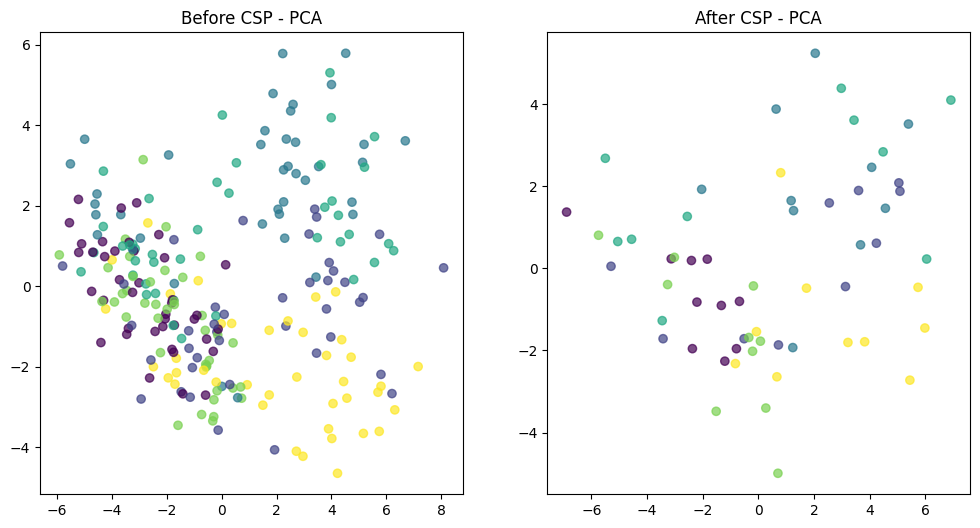

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming xtrain and xtest are your data before and after CSP
xtrain_before_csp = xtrain
xtest_after_csp = xtest

# Apply PCA for visualization
pca = PCA(n_components=2)

# Fit and transform the data
xtrain_pca = pca.fit_transform(xtrain_before_csp)
xtest_pca = pca.transform(xtest_after_csp)

# Plot the data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(xtrain_pca[:, 0], xtrain_pca[:, 1], c=ytrain, cmap='viridis', alpha=0.7)
plt.title('Before CSP - PCA')

plt.subplot(1, 2, 2)
plt.scatter(xtest_pca[:, 0], xtest_pca[:, 1], c=ytest, cmap='viridis', alpha=0.7)
plt.title('After CSP - PCA')

plt.show()


In [29]:
from sklearn.utils import shuffle
xtrain,ytrain=shuffle(xtrain,ytrain,random_state=2)

In [30]:
ytrain

array([4, 0, 0, 0, 4, 0, 1, 3, 2, 0, 5, 5, 5, 3, 5, 1, 2, 0, 2, 2, 0, 1,
       0, 4, 5, 3, 4, 2, 4, 5, 4, 0, 3, 1, 4, 3, 3, 2, 3, 1, 4, 0, 1, 2,
       2, 1, 3, 4, 2, 1, 4, 4, 3, 5, 2, 5, 1, 0, 4, 3, 5, 0, 1, 1, 2, 0,
       4, 1, 2, 4, 0, 1, 0, 4, 4, 0, 4, 1, 0, 4, 0, 5, 0, 1, 1, 0, 4, 5,
       3, 1, 5, 5, 2, 2, 1, 1, 0, 0, 1, 3, 2, 3, 4, 4, 0, 1, 3, 0, 1, 3,
       0, 2, 3, 2, 0, 2, 5, 3, 5, 2, 1, 4, 5, 4, 0, 2, 5, 0, 4, 5, 5, 2,
       1, 5, 5, 2, 2, 5, 4, 3, 0, 2, 3, 1, 5, 5, 3, 4, 5, 1, 5, 4, 0, 3,
       0, 2, 1, 5, 4, 4, 3, 4, 5, 0, 5, 2, 2, 0, 2, 0, 3, 5, 1, 1, 1, 4,
       3, 5, 3, 3, 5, 1, 0, 3, 5, 0, 2, 4, 4, 2, 2, 4, 3, 5, 2, 0, 4, 2,
       3, 5, 1, 3, 0, 4, 2, 3, 1, 2, 3, 3, 4, 1, 2, 4, 4, 0, 1, 3, 5, 5,
       3, 1, 3, 5, 2, 1, 1, 3, 3, 1, 2, 4, 5, 2, 0, 2, 5, 3, 1, 3])

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

ImportError: cannot import name 'confusion_matrix' from 'sklearn' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/__init__.py)

### SVM

In [32]:
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


NameError: name 'confusion_matrix' is not defined

Accuracy: 0.7


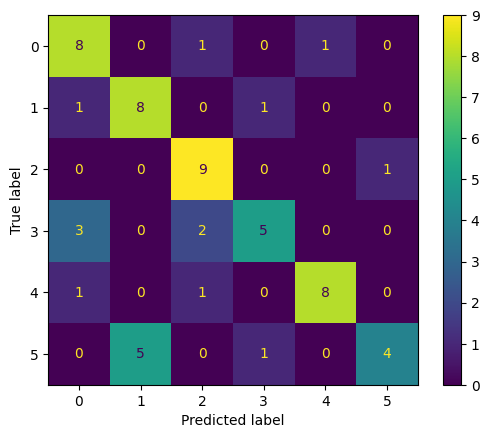

In [ ]:
from sklearn import svm
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()


# MLP

Accuracy: 0.6666666666666666


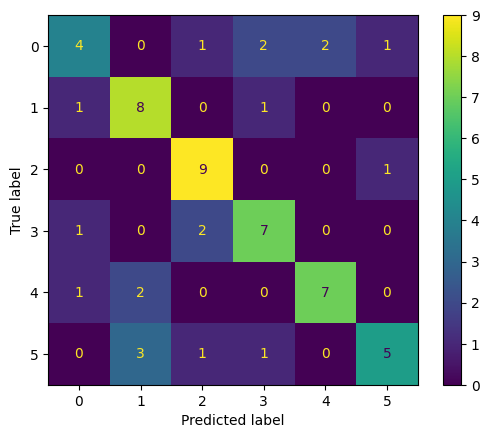

In [ ]:
from sklearn.neural_network import MLPClassifier

clf=MLPClassifier( hidden_layer_sizes=(128),max_iter=1000)#max 42%

#Train the model using the training sets
clf.fit(xtrain, ytrain)


y_pred = clf.predict(xtest)
cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# KNN

Accuracy: 0.5333333333333333


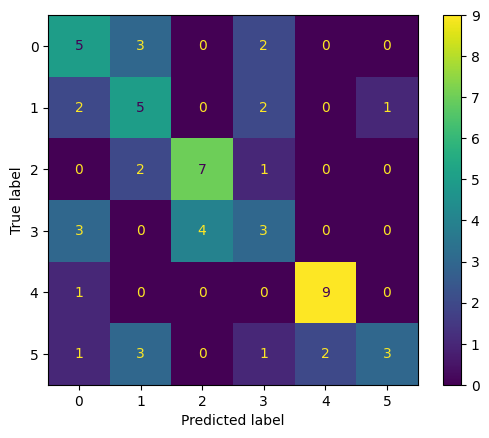

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf=KNeighborsClassifier(n_neighbors=7)
clf.fit(xtrain, ytrain)

y_pred = clf.predict(xtest)

cm=confusion_matrix(ytest, y_pred)

print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
disp=ConfusionMatrixDisplay(cm)
disp.plot()

# LSTM 

In [ ]:
X_train=xtrain
X_test=xtest
X_train.shape,xtrain.shape

((240, 60), (240, 60))

In [ ]:
import tensorflow as tf
def build_model(num_classes):

#     inputs = tf.keras.Input(shape=(X_train.shape[1],X_train.shape[2]))
# #     x = tf.keras.layers.Reshape((-1, 60))(inputs)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
#     x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
#     x = tf.keras.layers.LSTM(64)(x)
    inputs = tf.keras.Input(shape=(None, X_train.shape[1]))
    x = tf.keras.layers.Reshape((-1, X_train.shape[1]))(inputs)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
user_model = build_model(num_classes=6)
Epochs=300
checkpoint_path="weights.best.hdf5"
check_point = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,monitor='val_accuracy' ,save_weights_only=True, verbose=1)

user_history = user_model.fit(
    X_train,
    ytrain,
    epochs=Epochs,           
    batch_size=64,
    validation_data=(X_test,ytest)
,callbacks=[check_point])

Epoch 1/300
1/4 [======>.......................] - ETA: 13s - loss: 1.7918 - accuracy: 0.1562
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to weights.best.hdf5
4/4 [==============================] - 6s 443ms/step - loss: 1.7919 - accuracy: 0.1542 - val_loss: 1.7914 - val_accuracy: 0.1667
Epoch 2/300
1/4 [======>.......................] - ETA: 0s - loss: 1.7915 - accuracy: 0.1875
Epoch 2: val_accuracy improved from 0.16667 to 0.21667, saving model to weights.best.hdf5
4/4 [==============================] - 0s 29ms/step - loss: 1.7913 - accuracy: 0.1708 - val_loss: 1.7906 - val_accuracy: 0.2167
Epoch 3/300
1/4 [======>.......................] - ETA: 0s - loss: 1.7908 - accuracy: 0.2188
Epoch 3: val_accuracy improved from 0.21667 to 0.23333, saving model to weights.best.hdf5
4/4 [==============================] - 0s 25ms/step - loss: 1.7899 - accuracy: 0.2708 - val_loss: 1.7880 - val_accuracy: 0.2333
Epoch 4/300
1/4 [======>.......................] - ETA: 0s - loss: 1

2/2 [==============================] - 1s 4ms/step
Accuracy: 0.6166666666666667


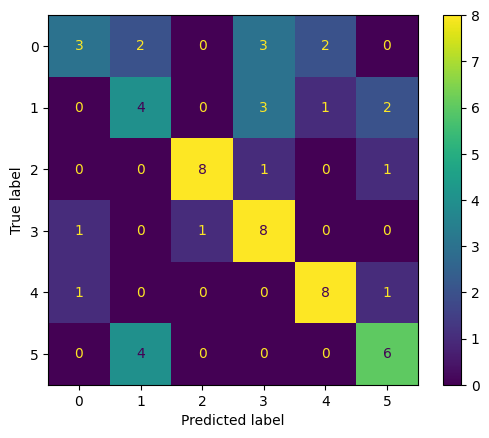

In [ ]:
user_model.load_weights('/Users/siddharth/Desktop/EEG_Classifier/Code/weights.best.hdf5')
y_pred = user_model.predict(X_test)

y_pred=[np.argmax(v) for v in y_pred]
print("Accuracy:",accuracy_score(ytest, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix

cm=confusion_matrix(ytest, y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()

In [ ]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import pacf
def compute_statistical(epochs): 
    import pywt
# Assuming your data is stored as epochs with shape (300, 60, 10000)
    # Compute statistical features for each epoch
    statistical_features = []
    for epoch in epochs:
        epoch_features = []
        for channel in epoch:
            
#             scales = np.arange(1, 5)
#             wavelet='mexh'
#             coefs, freqs = pywt.cwt(channel,scales,wavelet ) 
#                 coefs,                                 #cwt coefs
#                 acf(channel, nlags=10, method='ywadjusted', alpha=None) #partial autocorrelation
                
            channel_features = [
                
                np.mean(channel),                    # Mean
                np.std(channel),                     # Standard Deviation
                np.var(channel),                     # Variance
                skew(channel),                        # Skewness
                kurtosis(channel),                # Kurtosis
                np.sqrt(np.mean(channel**2)),
                np.mean(channel**2),
                np.max(np.abs(channel)),
                np.ptp(channel),
                np.max(np.abs(channel))/np.sqrt(np.mean(channel**2)),
                np.sqrt(np.mean(channel**2))/np.mean(channel),
                np.max(np.abs(channel))/np.mean(channel),

            ]
            epoch_features.extend(channel_features)
#         epoch_features = np.array(epoch_features)
        statistical_features.append(epoch_features)

    statistical_features = np.array(statistical_features)

    # Print the shape of the computed statistical features
    print("Statistical features shape:", statistical_features.shape)

    return statistical_features

In [ ]:
# Assuming you have already defined the compute_statistical function and have your data in epochs
features = compute_statistical(epochs)

# Print the features
print("Statistical Features:")
for epoch_idx, epoch_features in enumerate(features):
    print(f"Epoch {epoch_idx + 1}: {epoch_features}")


NameError: name 'epochs' is not defined

# Final Testing 

In [ ]:
late_test1.shape,late_test2.shape,late_label1,late_label2

((60, 11251), (60, 11251), 0, 2)